<a href="https://colab.research.google.com/github/gal-dmitry/HSE_DUL/blob/hw_14/Homework14_meta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 435, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 435 (delta 110), reused 82 (delta 80), pack-reused 250
Receiving objects: 100% (435/435), 70.49 MiB | 12.83 MiB/s, done.
Resolving deltas: 100% (204/204), done.
Checking out files: 100% (59/59), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=30522 sha256=07000a5345738604904836106fd940662ae368ebb617dd2a83eb94199fcec4c1
  Stored in directory: /tmp/pip-ephem-wheel-cac

In [2]:
from dul_2021.utils.hw14_utils import *

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import numpy as np
from torch.optim import Adam
from tqdm.auto import tqdm, trange

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

# Data

Here we will work MNIST dataset which is already preprocessed for meta learning. This dataset comes in a dataloader from. Train loader yields a pair of batch of images (`[2 * N_way * k_shot, 1, 28, 28]`) and batch of labeles (`[2 * N_way * k_shot]`). Where `N_way` means number of classes in each task and `k_shot` means number of samples for each class. Both images and labeles are concatenation of support set (train) and query set (test). You can split them with `split_batch(imgs, targets)`.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



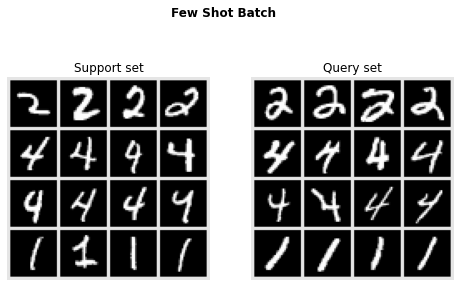

In [6]:
# data sample example
show_imgs()

# Question 1. Prototypical Networks


The Prototypical Network, or [ProtoNet](https://arxiv.org/pdf/1703.05175.pdf) for short, is a metric-based meta-learning algorithm that operates similarly to the nearest neighbor classification. Metric-based meta-learning methods classify a new example $\mathbf{x}$ based on some distance function $d_{\varphi}$ between $x$ and all elements in the support set. ProtoNets implements this idea with the concept of prototypes in a learned feature space. First, ProtoNet uses an embedding function $f_{\theta}$ to encode each input in the support set into a $L$-dimensional feature vector. Next, for each class $c$, we collect the feature vectors of all examples with label $c$ and average their feature vectors. Formally, we can define this as:

$$\mathbf{v}_c=\frac{1}{|S_c|}\sum_{(\mathbf{x}_i,y_i)\in S_c}f_{\theta}(\mathbf{x}_i)$$

where $S_c$ is the part of the support set $S$ for which $y_i=c$, and $\mathbf{v}_c$ represents the _prototype_ of class $c$. The prototype calculation is visualized below for a 2-dimensional feature space and 3 classes. The colored dots represent encoded support elements with the color-corresponding class labels, and the black dots next to the class label are the averaged prototypes. 

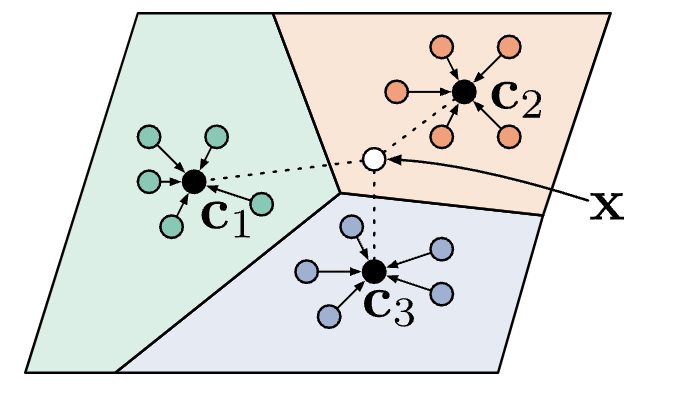

Based on these prototypes, we want to classify a new example. Remember that since we want to learn the encoding function $f_{\theta}$, this classification must be differentiable, and hence, we need to define a probability distribution across classes. For this, we will make use of the distance function $d_{\varphi}$: the closer a new example $\mathbf{x}$ is to a prototype $\mathbf{v}_c$, the higher the probability for $\mathbf{x}$ belonging to class $c$. Formally, we can simply use a softmax over the distances of $\mathbf{x}$ to all class prototypes:

$$p(y=c\vert\mathbf{x})=\text{softmax}(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_c))=\frac{\exp\left(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_c)\right)}{\sum_{c'\in \mathcal{C}}\exp\left(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_{c'})\right)}$$

Note that the negative sign is necessary since we want to increase the probability for close-by vectors and have a low probability for distant vectors. We train the network $f_{\theta}$ based on the cross-entropy error of the training query set examples. Thereby, the gradient flows through both the prototypes $\mathbf{v}_c$ and the query set encodings $f_{\theta}(\mathbf{x})$. For the distance function $d_{\varphi}$, we can choose any function as long as it is differentiable concerning both of its inputs. The most common function, which we also use here, is the squared euclidean distance, but there have been several works on different distance functions as well.


* We will work with 4-way 4-shot classifications during training and 3-way 4-shot classification during test

* You can use architecture from practice

**Hyperparameters**

* lr = 1e-3
* num_epochs = 20



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. Model with a `adapt_few_shots` method

**adapt_few_shots**

```
@torch.no_grad()
def adapt_few_shots(self, batch, dloader):
    """
    batch: n-way_test k-shot_test batch (pair) of images ([k_shot_test * n-way_test, 1, 28, 28]) \\
            and labeles [k_shot_test * n-way_test])
    dloader: dataloader for the test set. yields batches of images ([batch_size, 1, 28, 28])\\
              with their labelel ([batch_size])

     returns pred: np.array of predicted classed for each images in dloader (don't shuffle it)
    """
    
    return pred
```

In [7]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )


class Net(nn.Module):
    def __init__(self, x_dim=1, hid_dim=64, z_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            conv_block(x_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, z_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

In [25]:
class ProtoNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.net = Net()


    @staticmethod
    def distance(a, b):
        # print(f"a: {a}")
        # print(f"b: {b}")
        if len(a.shape) < 2:
            a = torch.unsqueeze(a, 0)
        if len(b.shape) < 2:
            b = torch.unsqueeze(b, 0)
        return torch.cdist(a, b)


    def predict_proba(self, query_emb, mean_embs):
        return F.softmax(-self.distance(query_emb, mean_embs))


    def predict(self, query_embs, mean_embs, unique_targets):
        distances = self.distance(query_embs, mean_embs)
        predict_proba = F.softmax(-distances, dim=1)
        ind = torch.argmax(predict_proba, dim=1).cpu().numpy()
        pred = unique_targets[ind]
        return pred


    def get_mean_embs(self, sup_emb, support_targets, unique_labels):
        mean_embs = []
        for c in unique_labels:
            v_c = sup_emb[support_targets == c].mean(dim=0)
            mean_embs.append(torch.unsqueeze(v_c, 0))
        # print(f"_mean_embs: {mean_embs}")
        return torch.cat(mean_embs)


    def train(self, train_data_loader, num_epochs=20, lr=1e-3):

        optim = Adam(self.net.parameters(), lr=lr)
        losses = []

        for epoch in trange(num_epochs, desc="Fit"):
            
            for (imgs, targets) in tqdm(train_data_loader, desc="Batch: fit"):
                imgs, targets = imgs.to(device), targets.to(device)
                support_imgs, query_imgs, support_targets, query_targets = split_batch(imgs, targets)

                unique_targets = support_targets.unique()
                # print(f"unique_targets: {unique_targets}")

                assert np.setdiff1d(query_targets.cpu(), unique_targets.cpu()).shape[0] == 0, \
                "support targets do not contain all possible classes"
                
                N_c = unique_targets.shape[0]
                N_q = query_targets.shape[0]

                sup_embs = self.net(support_imgs)
                query_embs = self.net(query_imgs)
                mean_embs = self.get_mean_embs(sup_embs, support_targets, unique_targets)
                # print(f"mean_embs: {mean_embs}")

                loss = torch.Tensor([0]).to(device)
                for i, target in enumerate(unique_targets):
                    mean_emb = mean_embs[i]
                    for query_emb in query_embs[support_targets == target]:

                        distance = self.distance(query_emb, mean_emb)
                        distance_matrix = self.distance(query_emb, mean_embs)
                        probs = torch.logsumexp(-torch.squeeze(distance_matrix), 0)
                        
                        # print(f"distance: {distance}")
                        # print()
                        # print(f"query_emb: {query_emb}")
                        # print(f"mean_embs: {mean_embs}")
                        # print(f"distance_matrix: {distance_matrix}")
                        # print(f"probs: {probs}")

                        delta = (torch.squeeze(distance) + torch.squeeze(probs)) / (N_c * N_q)
                        # print(f"delta: {delta}")
                        loss += delta

                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.item())

        return losses


    @torch.no_grad()
    def adapt_few_shots(self, batch, dloader):
        """
        batch: n-way_test k-shot_test batch (pair) of images ([k_shot_test * n-way_test, 1, 28, 28]) \\
                and labeles [k_shot_test * n-way_test])
        dloader: dataloader for the test set. yields batches of images ([batch_size, 1, 28, 28])\\
                with their labelel ([batch_size])

        returns pred: np.array of predicted classed for each images in dloader (don't shuffle it)
        """
        
        support_imgs, support_targets = batch
        support_imgs, support_targets = support_imgs.to(device), support_targets.to(device)
        unique_targets = support_targets.unique().cpu().numpy()

        sup_embs = self.net(support_imgs)
        mean_embs = self.get_mean_embs(sup_embs, support_targets, unique_targets)

        pred = []
        for (query_imgs, query_targets) in tqdm(dloader, desc="Batch: test"):
            query_imgs, query_targets = query_imgs.to(device), query_targets.to(device)
            
            assert np.setdiff1d(query_targets.cpu(), unique_targets).shape[0] == 0, \
            "support targets do not contain all possible classes"

            query_embs = self.net(query_imgs)
            query_preds = self.predict(query_embs, mean_embs, unique_targets)
            # print(f"query_preds: {query_preds}")
            
            pred.extend(query_preds.tolist())

        pred = np.array(pred)

        # print(f"test: unique_targets: {unique_targets}")
        # print(f"test: pred: {pred}")
        # print()

        return pred

In [24]:
def q1(train_data_loader):
    """
    train_data_loader: dataloader 4-way 4-shot classification

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - model with a adapt_few_shots method
    """

    num_epochs=20
    # num_epochs = 1
    lr=1e-3

    model = ProtoNet().to(device)
    losses = model.train(train_data_loader, num_epochs=num_epochs, lr=lr)

    return losses, model

Fit:   0%|          | 0/20 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/1528 [00:00<?, ?it/s]

Batch: test:   0%|          | 0/106 [00:00<?, ?it/s]

Batch: test:   0%|          | 0/106 [00:00<?, ?it/s]

Batch: test:   0%|          | 0/106 [00:00<?, ?it/s]

Batch: test:   0%|          | 0/106 [00:00<?, ?it/s]

Batch: test:   0%|          | 0/106 [00:00<?, ?it/s]

Batch: test:   0%|          | 0/106 [00:00<?, ?it/s]

Batch: test:   0%|          | 0/106 [00:00<?, ?it/s]

Batch: test:   0%|          | 0/106 [00:00<?, ?it/s]

Batch: test:   0%|          | 0/106 [00:00<?, ?it/s]

Batch: test:   0%|          | 0/106 [00:00<?, ?it/s]

test accuracy=0.8587


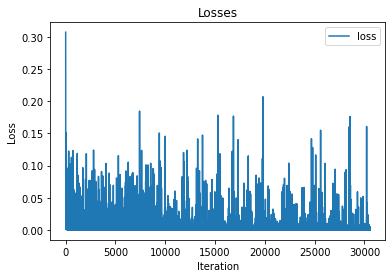

In [26]:
### cuda
q1_results(q1)

  0%|          | 0/20 [00:00<?, ?it/s]

test accuracy=0.7860


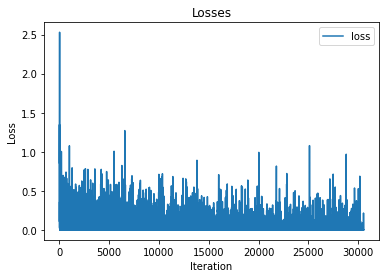

In [ ]:
### orig
q1_results(q1)

# Bonus. [ProtoMaml](https://arxiv.org/pdf/1903.03096.pdf)

A problem of MAML is how to design the output classification layer. In case all tasks have a different number of classes, we need to initialize the output layer with zeros or randomly in every iteration. Even if we always have the same number of classes, we just start from random predictions. This requires several inner loop steps to reach a reasonable classification result. To overcome this problem we can use prototypes to initialize our output layer to have a strong initialization. Thereby, it can be shown that the softmax over euclidean distances can be reformulated as a linear layer with softmax. To see this, let's first write out the negative Euclidean distance between a feature vector $f_{\theta}(\mathbf{x}^{*})$ of a new data point $\mathbf{x}^{*}$ to a prototype $\mathbf{v}_c$ of class $c$:

$$
-||f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c||^2=-f_{\theta}(\mathbf{x}^{*})^Tf_{\theta}(\mathbf{x}^{*})+2\mathbf{v}_c^{T}f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c^T\mathbf{v}_c
$$

We perform the classification across all classes $c\in\mathcal{C}$ and take a softmax on the distance. Hence, any term that is the same for all classes can be removed without changing the output probabilities. In the equation above, this is true for $-f_{\theta}(\mathbf{x}^{*})^Tf_{\theta}(\mathbf{x}^{*})$ since it is independent of any class prototype. Thus, we can write:

$$
-||f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c||^2=2\mathbf{v}_c^{T}f_{\theta}(\mathbf{x}^{*})-||\mathbf{v}_c||^2+\text{constant}
$$

Taking a second look at the equation above, it looks a lot like a linear layer. For this, we use $\mathbf{W}_{c,\cdot}=2\mathbf{v}_c$ and $b_c=-||\mathbf{v}_c||^2$ which gives us the linear layer $\mathbf{W}f_{\theta}(\mathbf{x}^{*})+\mathbf{b}$. Hence, if we initialize the output weight with twice the prototypes, and the biases by the negative squared L2 norm of the prototypes, we start with a Prototypical Network. MAML allows us to adapt this layer and the rest of the network further. 

* We will work with 2-way 4-shot classifications during training and 2-way 4-shot classification during test. However, dataloader will yield larger batches, which you need to reshape into `[batch_size, 2 * n-way * k-shot, 1, 28, 28]`

* You can use architecture from practice

* You can use higher or use first order approximation of gradients. This means that the second-order gradients are ignored, and we can calculate the outer loop gradients (line 10 in algorithm 2) simply by calculating the gradients with respect to $\theta_i'$ and use those as an update to $\theta$. Hence, the new update rule becomes:

$$
\theta\leftarrow\theta-\beta\sum_{\mathcal{T}_i\sim p(\mathcal{T})}\nabla_{\theta_i'}\mathcal{L}_{\mathcal{T}_i}(f_{\theta_i'})
$$

Note the change of $\theta$ to $\theta_i'$ for $\nabla$.


**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. Model with a `adapt_few_shots` method

**adapt_few_shots**

```
@torch.no_grad()
def adapt_few_shots(self, batch, dloader):
    """
    batch: n-way_test k-shot_test batch (pair) of images ([k_shot_test * n-way_test, 1, 28, 28]) \\
            and labeles [k_shot_test * n-way_test])
    dloader: dataloader for the test set. yields batches of images ([batch_size, 1, 28, 28])\\
              with their labelel ([batch_size])

     returns pred: np.array of predicted classed for each images in dloader (don't shuffle it)
    """
    
    return pred
```

In [ ]:
def b(train_data_loader):
    """
    train_data_loader: dataloader 16-way 4-shot classification

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - model with a adapt_few_shots method
    """

In [ ]:
b_results(b)